### Noms et Prénoms du binome: BENICHOU Yaniv - BONNEFOY Nicolas

---

# TP en Watermarking et Stéganographie

---

## Patrick Bas, CNRS, CRIStAL

---


 

## Tatouage par également de spectre et attaques de sécurité

### Notations et rappels:

Les notations sont identiques à celles vues en cours. Le procédé d'insertion est le schéma par étalement de spectre vu en cours.

* X = matrice de $N_{i}$ vecteurs originaux de taille $N_{v}$ ($N_{i}$ colonnes, $N_{v}$ lignes). $N_{i}$ représente par exemple le nombre de contenu traités, et $N_{v}$ le nombre de composantes tatouées par contenu. **Note**: chaque colonne de X peut par exemple représenter des composantes d'une image.
* $N_{o}$ représente le nombre de contenus tatoués observés par l'adversaire et utilisés pour construire son attaque
* $N_{i}$ représente le nombre de contenus tatoués utilisés pour calculer pratiquement le taux d'erreur (voir BER)
* Y = matrice de contenus tatoués
* Z = matrice de contenus tatoués et perturbés
* k clé secrète de norme unitaire
* $m_{1}$: bit inséré, converti en +1, -1 
* $\alpha$: paramètre de distorsion
* BER: Bit Error Rate, taux d'erreur binaire ou encore probabilité d'erreur empirique de décodage

#### Rappels:
* L'objectif du récepteur et de bien décoder $m_{1}$, possiblement en ayant une distortion qui ne soit pas trop importante
* Ici, les objectifs de l'adversaire sont d'estimer une version k ou +/-k puis d'effacer le message inséré. Pour s'assurer que l'adversaire a bien réussi à estimer k ou +/-k, il calculera la correlation normalisée entre le vecteur k et son estimation.

**N'oubliez pas d'exporter votre TP en pdf de préférence ou éventuellement en html lors de sa remise**



In [1]:
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from scipy.special import erf
from sklearn.decomposition import FastICA

## Scénario 1: Attaque à Messages connus, 1 bit
* Mise en route: Quel est le BER cible de l'adversaire ?
* Mettre en place l'attaque liée à ce scénario
* Etudier l'impact de $N_{o}$ et de $\alpha$ sur le BER après attaque

> Le BER cible de l'adversaire est de 50% pour que le décodage du message tatoué devient aussi aléatoire qu'un tirage à pile ou face, rendant le message indéchiffrable et atteignant ainsi l'objectif de l'adversaire de neutraliser efficacement le tatouage.


In [2]:
Nv = 100 # Size of the vector
Ni = 10000 # Max number of observations

In [3]:
# Compute the Bit Error Rate between message m and the extracted message from Y using key k
def ber(Y,m,k):
    c = np.sign(np.dot(Y.T,k))
    return np.sum(c != m)/float(Ni)

# Compute the Normalised correlation
def norm_corr(hatk,k):
    hatk = hatk / np.sqrt(np.dot(hatk.T,hatk)) # Normalize
    corrN = np.abs(np.dot(hatk.T,k))/(np.linalg.norm(hatk)*np.linalg.norm(k)) 
    return corrN

def do_process(alpha,No):
    #print(f'alpha: {alpha}, No: {No}')
    X = np.random.randn(Nv,Ni) # Generate Ni random host vectors
    k = np.random.randn(Nv,1) # Generate de Watermark
    k = k / np.sqrt(np.dot(k.T,k)) # Normalize the watermark

    m1 = np.ones((Ni,1)) #Scenario with Known Messages: generate only ones
    K = np.dot(k,m1.T) # Generate the matrix of watermarks (each column contains m1_i*k)
    W = alpha*K
    Y = X + W # perform embedding


    #cY = np.sign(np.dot(Y.T,k)) # Computation of the decoded 'bits' (here -1 or +1)
    #print('practical bit error rate:')
    #print(np.sum(cY != m1)/np.float(Ni)) 

    Y_obs = Y[:,:No]
    # To Do: implement the attack on No observation, i.e. on Y[:,:No]
    
    hatk = np.mean(Y_obs, axis=1)
    hatk = hatk / np.sqrt(np.dot(hatk.T,hatk)) # We need to Normalize
    
    corrN = np.abs(np.dot(hatk.T,k))/(np.linalg.norm(hatk)*np.linalg.norm(k)) # Compute the Normalised correlation
    #print('Normalised correlation between the true key and the estimated key')
    #print(corrN)

    hatk = np.reshape(hatk,(Nv,1))# We need to reshape

    YA = Y - alpha*np.dot(hatk,m1.T) # perform the removal attack
    #print('BER après attaque:', ber(YA, m1, k))
    #print('\n\n')
    return ber(YA, m1, k), corrN[0]

    
alpha = 2 # Tune the power of the watermark here

# Réinitialisation des vecteurs pour les plots
ber_values = []
corr_values = []
No_values = range(100,Ni,100) 

# One example, can be used to draw plots
for No in No_values:
    ber_val, corr_val = do_process(alpha, No)
    ber_values.append(ber_val)
    corr_values.append(corr_val)


# Graphique du BER
fig_ber = go.Figure()
fig_ber.add_trace(go.Scatter(x=list(No_values), y=ber_values, mode='lines+markers', name='BER après attaque'))
fig_ber.add_hline(y=0.5, line_dash="dot", line_color="red", annotation_text="BER 50%", annotation_position="bottom left")
fig_ber.update_layout(
    title="BER après attaque en fonction de No",
    xaxis_title="No (Nombre d'observations)",
    yaxis_title="BER",
    width=700,
    height=400
)
fig_ber.show()

# Graphique du Corr
fig_corr = go.Figure()
fig_corr.add_trace(go.Scatter(x=list(No_values), y=corr_values, mode='lines+markers', name='Corr après attaque'))
fig_corr.add_hline(y=1, line_dash="dot", line_color="red", annotation_text="Corr = 1", annotation_position="bottom left")
fig_corr.update_layout(
    title="Corr après attaque en fonction de No",
    xaxis_title="No (Nombre d'observations)",
    yaxis_title="Cor",
    width=700,
    height=400
)
fig_corr.show()

In [4]:
alpha_values = [0.2, 0.5, 1, 1.5, 2, 2.5, 3] # Tune the power of the watermark here
Ni_grand = 20000

fig_ber = go.Figure()
fig_corr = go.Figure()
fig_ber.add_hline(y=0.5, line_dash="dot", line_color="red", annotation_text="BER 50%", annotation_position="top left")
fig_corr.add_hline(y=1, line_dash="dot", line_color="red", annotation_text="Corr = 1", annotation_position="top left")

for alpha in alpha_values:
    # Réinitialisation des vecteurs pour les plots
    ber_values = []
    corr_values = []
    No_values = range(100,Ni_grand,100) 
    for No in No_values:
        ber_val, corr_val = do_process(alpha, No)
        ber_values.append(ber_val)
        corr_values.append(corr_val)
    # Graphique du BER
    fig_ber.add_trace(go.Scatter(x=list(No_values), y=ber_values, mode='lines+markers', name=f'alpha = {alpha}'))
    # Graphique du Corr
    fig_corr.add_trace(go.Scatter(x=list(No_values), y=corr_values, mode='lines+markers', name=f'alpha = {alpha}'))
fig_corr.update_layout(
    title="Impact de No et alpha sur le Corr après attaque",
    xaxis_title=f"No (Nombre d'observations)={Ni}",
    yaxis_title="Cor",
    legend_title='Valeurs de alpha',
    width=800,
    height=500
)
    
fig_ber.update_layout(
    title='Impact de No et alpha sur le BER après attaque',
    xaxis_title=f'No (Nombre d‘observations)={Ni}',
    yaxis_title='BER',
    legend_title='Valeurs de alpha',
    width=800,
    height=500
)
fig_ber.show()
fig_corr.show()

> En faisant varier alpha et N0, on remarque que toutes les courbes convergnet vers un BER de 0.5. Ceoendant, un alpha trop faible (comme 0.2), a plus de mal a convergé et suggère une plus grande résistance à l'attaque (car légèrement en dessous de BER = 0.5). 
>
> Mis à part cet exemple, le fait que le BER reste autour de 0.5 pour la plupart des valeurs de α suggère que l'attaque est généralement efficace, rendant le processus de décodage presque aléatoire. L'observation d'un BER légèrement inférieur à 0.5 pour α=0.2 indique que le tatouage moins robuste est un peu plus résistant à cette attaque spécifique. Cela pourrait impliquer qu'un tatouage plus discret (moins perceptible) est légèrement plus efficace contre cette méthode d'attaque. Ces résultats soulignent un équilibre entre la robustesse et la discrétion du tatouage, indiquant qu'une augmentation de la force du tatouage ne garantit pas nécessairement une meilleure sécurité contre les attaques dans ce contexte particulier.
>
> (Insertion moins robuste)

## Scénario 2, Attaque à messages inconnus, 1bit
* Note: la fonction `np.linalg.eig` peut être utilisée pour effectuer une décomposition en valeurs et vecteurs propres.
* Note: pour effacer le message inséré, il conviendra au préalable d'estimer le "bit" inséré (m=-1 ou m=1), cela peut se faire via `m_est = np.sign(np.dot(Y.T,hatk))` où `hatk` est la clé estimée
* Mettre en place l'attaque
* Etudier l'impact de $N_{o}$ et de $\alpha$ sur le BER après attaque

In [5]:
# 2dn scenario, scenario with KMA 
print('2nd Scenario')

def do_process(alpha,No):
    X = np.random.randn(Nv,Ni) # Generate Ni random host vectors
    k = np.random.randn(Nv,1) # Generate de Watermark
    k = k / np.sqrt(np.dot(k.T,k)) # Normalize the watermark

    m1 = np.sign(np.random.randn(Ni,1)) #Scenario with unknow messages, first bit
    K = np.dot(k,m1.T) # Generate the matrix of watermarks (each column contains m1_i*k)
    W = alpha*K
    Y = X + W # perform embedding
    Y_obs = Y[:,:No]
    #hatk = TO DO
    #get eigenvalues and eigenvectors
    cov = np.dot(Y_obs,Y_obs.T)
    eigvals, eigvecs = np.linalg.eig(cov)
    #sort eigenvalues and eigenvectors
    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:,idx]
    #get the first eigenvector
    hatk=eigvecs[:,0]
    
    hatk = np.reshape(hatk,(Nv,1)) #You might need to reshape the estimated key

    corrN = norm_corr(hatk,k)# To ease the writing we use the norm_corr function

    #print('Normalised correlation between the true key and the estimated key')
    #print(corrN)

    #m_est = TO DO
    #YA = TO DO 
    m_est = np.sign(np.dot(Y.T, hatk)) 
    YA = Y - alpha * np.dot(hatk, m_est.T)  # Appliquer l'attaque

    #print('bit error rate after security attack')
    #print(ber(YA,m1,k))
    #print('\n\n')
    return ber(YA, m1, k), corrN[0][0]


alpha = 2   
Ni = 20000 
# Réinitialisation des vecteurs pour les plots
ber_values = []
corr_values = []
No_values = range(100,Ni,100) 

# One example, can be used to draw plots
for No in No_values:
    ber_val, corr_val = do_process(alpha, No)
    ber_values.append(ber_val)
    corr_values.append(corr_val)


# Graphique du BER
fig_ber = go.Figure()
fig_ber.add_trace(go.Scatter(x=list(No_values), y=ber_values, mode='lines+markers', name='BER après attaque'))
fig_ber.add_hline(y=0.5, line_dash="dot", line_color="red", annotation_text="BER 50%", annotation_position="bottom left")
fig_ber.update_layout(
    title="BER après attaque en fonction de No",
    xaxis_title="No (Nombre d'observations)",
    yaxis_title="BER",
    width=700,
    height=400
)
fig_ber.show()

# Graphique du Corr
fig_corr = go.Figure()
fig_corr.add_trace(go.Scatter(x=list(No_values), y=corr_values, mode='lines+markers', name='Corr après attaque'))
fig_corr.add_hline(y=1, line_dash="dot", line_color="red", annotation_text="Corr = 1", annotation_position="bottom left")
fig_corr.update_layout(
    title="Corr après attaque en fonction de No",
    xaxis_title="No (Nombre d'observations)",
    yaxis_title="Cor",
    width=700,
    height=400
)
fig_corr.show()

2nd Scenario


In [6]:
alpha_values = [0.2, 0.5, 1, 1.5, 2, 2.5, 3] # Tune the power of the watermark here
Ni_grand = 20000

fig_ber = go.Figure()
fig_corr = go.Figure()
fig_ber.add_hline(y=0.5, line_dash="dot", line_color="red", annotation_text="BER 50%", annotation_position="top left")
fig_corr.add_hline(y=1, line_dash="dot", line_color="red", annotation_text="Corr = 1", annotation_position="top left")

for alpha in alpha_values:
    # Réinitialisation des vecteurs pour les plots
    ber_values = []
    corr_values = []
    No_values = range(100,Ni_grand,100) 
    for No in No_values:
        ber_val, corr_val = do_process(alpha, No)
        ber_values.append(ber_val)
        corr_values.append(corr_val)
    # Graphique du BER
    fig_ber.add_trace(go.Scatter(x=list(No_values), y=ber_values, mode='lines+markers', name=f'alpha = {alpha}'))
    # Graphique du Corr
    fig_corr.add_trace(go.Scatter(x=list(No_values), y=corr_values, mode='lines+markers', name=f'alpha = {alpha}'))
fig_corr.update_layout(
    title="Impact de No et alpha sur le Corr après attaque",
    xaxis_title=f"No (Nombre d'observations)={Ni}",
    yaxis_title="Cor",
    legend_title='Valeurs de alpha',
    width=800,
    height=500
)
    
fig_ber.update_layout(
    title='Impact de No et alpha sur le BER après attaque',
    xaxis_title=f'No (Nombre d‘observations)={Ni}',
    yaxis_title='BER',
    legend_title='Valeurs de alpha',
    width=800,
    height=500
)
fig_ber.show()
fig_corr.show()

## Scénario 3: Attaque à messages inconnus, 2 bits
* Vérifier que l'attaque précédente ne permet pas d'estimer les deux clés. 
* Estimer au moins l'une des clés utilisée
    * Note: on pourra utiliser l'algorithme `FastICA` pour estimer les deux composantes indépendantes 
    * Pour cela on pourra appeler la fonction fastica en spécifiant que l'analyse en composantes indépendantes s'effectuera sur un sous espace engendré par les *deux premières composantes principales* (`n_components=2`), et en récupérant les colonnes de la matrice de mélange A (obtenue via `ica.mixing_`) estimé par l'algorithme.
    * Vérifier, à l'aide de la corrélation normalisée, que cette méthode permet d'estimer la clé `k1`
* Mettre en place l'attaque qui permet les deux bits
* Etudier l'impact de $N_{o}$ et de $\alpha$ sur le BER après attaque

In [24]:
# 3rd scenario, 2 bits
print('3rd scenario, 2bits')

m1 = np.sign(np.random.randn(Ni,1))#Scenario with unknow messages, first bit
m2 = np.sign(np.random.randn(Ni,1))#Scenario with unknow messages, second bit

k1 = np.random.randn(Nv,1) # Generate de Watermark
k1 = k1 / np.sqrt(np.dot(k1.T,k1)) # Normalize the watermark

k2 = np.random.randn(Nv,1) # Generate de Watermark
k2 = k2 / np.sqrt(np.dot(k2.T,k2)) # Normalize the watermark

def do_process(alpha,No):
    #print('alpha: ',alpha)
    #print('No: ',No)

    X = np.random.randn(Nv,Ni) # Generate Ni random host vectors
    K = np.dot(k1,m1.T) + np.dot(k2,m2.T) # Generate the matrix of watermarks (each column contains m1_i*k)
    W = alpha*K
    Y = X + W # perform embedding
    Y_obs = Y[:,:No]
    # TO DO
    
    # hatk_1 = TO DO
    hatk_1 =FastICA(n_components=2).fit(Y_obs.T).mixing_[:,0]
    hatk_1 = np.reshape(hatk_1,(Nv,1))

    corrN_1 = norm_corr(hatk_1,k1) # Compute the Normalised correlation
    

    corrN_2 = norm_corr(hatk_1,k2) # Compute the Normalised correlation
    

    # Perform the attack
    # To do
    YA_1 =  Y - alpha*np.dot(hatk_1,m1.T)
    YA_2 =  Y - alpha*np.dot(hatk_1,m2.T)
    return max(ber(YA_2, m1, k1),ber(YA_1, m2, k2)), np.max([corrN_1[0][0], corrN_2[0][0]])


alpha = 2   
Ni = 20000 
# Réinitialisation des vecteurs pour les plots
ber_values = []
corr_values = []
No_values = range(100,Ni,100) 

# One example, can be used to draw plots
for No in No_values:
    ber_val, corr_val = do_process(alpha, No)
    ber_values.append(ber_val)
    corr_values.append(corr_val)


# Graphique du BER
fig_ber = go.Figure()
fig_ber.add_trace(go.Scatter(x=list(No_values), y=ber_values, mode='lines+markers', name='BER après attaque'))
fig_ber.add_hline(y=0.5, line_dash="dot", line_color="red", annotation_text="BER 50%", annotation_position="bottom left")
fig_ber.update_layout(
    title="BER après attaque en fonction de No",
    xaxis_title="No (Nombre d'observations)",
    yaxis_title="BER",
    width=700,
    height=400
)
fig_ber.show()

# Graphique du Corr
fig_corr = go.Figure()
fig_corr.add_trace(go.Scatter(x=list(No_values), y=corr_values, mode='lines+markers', name='Corr après attaque'))
fig_corr.add_hline(y=1, line_dash="dot", line_color="red", annotation_text="Corr = 1", annotation_position="bottom left")
fig_corr.update_layout(
    title="Corr après attaque en fonction de No",
    xaxis_title="No (Nombre d'observations)",
    yaxis_title="Cor",
    width=700,
    height=400
)
fig_corr.show()


3rd scenario, 2bits


In [25]:
alpha_values = [0.2, 0.5, 1, 1.5, 2, 2.5, 3] # Tune the power of the watermark here
Ni_grand = 20000

fig_ber = go.Figure()
fig_corr = go.Figure()
fig_ber.add_hline(y=0.5, line_dash="dot", line_color="red", annotation_text="BER 50%", annotation_position="top left")
fig_corr.add_hline(y=1, line_dash="dot", line_color="red", annotation_text="Corr = 1", annotation_position="top left")

for alpha in alpha_values:
    # Réinitialisation des vecteurs pour les plots
    ber_values = []
    corr_values = []
    No_values = range(100,Ni_grand,100) 
    for No in No_values:
        ber_val, corr_val = do_process(alpha, No)
        ber_values.append(ber_val)
        corr_values.append(corr_val)
    # Graphique du BER
    fig_ber.add_trace(go.Scatter(x=list(No_values), y=ber_values, mode='lines+markers', name=f'alpha = {alpha}'))
    # Graphique du Corr
    fig_corr.add_trace(go.Scatter(x=list(No_values), y=corr_values, mode='lines+markers', name=f'alpha = {alpha}'))
fig_corr.update_layout(
    title="Impact de No et alpha sur le Corr après attaque",
    xaxis_title=f"No (Nombre d'observations)={Ni}",
    yaxis_title="Cor",
    legend_title='Valeurs de alpha',
    width=800,
    height=500
)
    
fig_ber.update_layout(
    title='Impact de No et alpha sur le BER après attaque',
    xaxis_title=f'No (Nombre d‘observations)={Ni}',
    yaxis_title='BER',
    legend_title='Valeurs de alpha',
    width=800,
    height=500
)
fig_ber.show()
fig_corr.show()

C:\Users\NICOLAS\AppData\Roaming\Python\Python39\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning:

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.

C:\Users\NICOLAS\AppData\Roaming\Python\Python39\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning:

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.

C:\Users\NICOLAS\AppData\Roaming\Python\Python39\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning:

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.

C:\Users\NICOLAS\AppData\Roaming\Python\Python39\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning:

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.

C:\Users\NICOLAS\AppData\Roaming\Python\Python39\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning:

FastICA d

## Etude de la robustesse
* Calculer le taux d'erreur (BER pour Bit Error Rate) théorique après ajout de bruit (voir cours)
* Etudier l'évolution de la robustesse (via le BER) en fonction de la distortion (via le paramètre $\alpha$) 


  0%|          | 0/45 [00:00<?, ?it/s]

C:\Users\NICOLAS\AppData\Roaming\Python\Python39\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning:

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.

C:\Users\NICOLAS\AppData\Roaming\Python\Python39\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning:

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.

C:\Users\NICOLAS\AppData\Roaming\Python\Python39\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning:

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.

C:\Users\NICOLAS\AppData\Roaming\Python\Python39\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning:

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.

C:\Users\NICOLAS\AppData\Roaming\Python\Python39\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning:

FastICA d

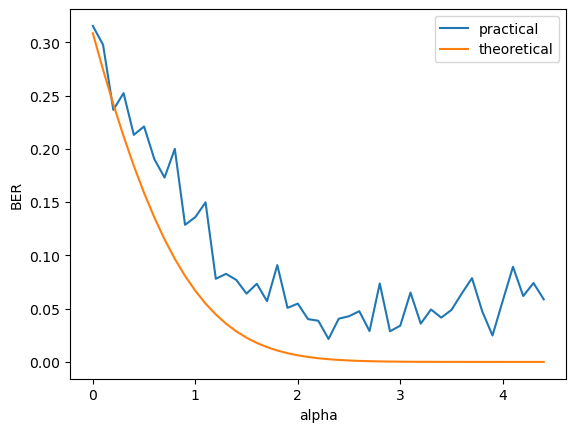

In [32]:
#import the erf function
from scipy.special import erf
from tqdm import tqdm
def ber_theorique(alpha):
    return 1/2*(1+erf(-alpha/np.sqrt(2)))


#study the impact of alpha on the robustess thorugh the BER
ber_list = []
ber_theo_list = []
alpha_list=[0.1*i for i in range(45)]
No=50
for alpha in tqdm(alpha_list):
    temp = []
    alpha+=0.5
    for n in range(No):
        X = np.random.randn(Nv,Ni)
        K = np.dot(k1,m1.T) + np.dot(k2,m2.T) 
        W = alpha*K
        Y = X + W 
        Y_obs = Y[:,:No]
        hatk_1 =FastICA(n_components=2).fit(Y_obs.T).mixing_[:,0]
        hatk_1 = np.reshape(hatk_1,(Nv,1))
        YA_1 =  Y - alpha*np.dot(hatk_1,m1.T)
        temp.append(min(1-ber(YA_1, m1, k1),ber(YA_1, m1, k1)))
    ber_theo_list.append(ber_theorique(alpha))
    ber_list.append(np.mean(temp))

plt.plot( alpha_list, ber_list)
plt.plot( alpha_list, ber_theo_list)
plt.xlabel('alpha')
plt.legend(['practical','theoretical']) 
plt.ylabel('BER')
plt.show()

    




## Conclusions
* Pourquoi un compromis entre la robustesse et la sécurité est-il inévitable ?